# Linear fit when both X and Y have uncertainties

We consider a true value (truth) that is unknown, and two observation systems $O_1$ and $O_2$ that both measure the truth with some unknown uncertatinties. This is a very common problem in geosciences when e.g. $O_1$ is from a model and $O_2$ from a satellite, or $O_1$ from a buoy and $O_2$ from a satellite or a model.

This notebook investigates the computation of linear fit lines when both $O_1$ and $O_2$ are measured with uncertainties (both are unbiased, but with Gaussian noise). By construction, the ordinary least square (OLS) method only considers uncertainties in the $O_2$ samples (the $O_1$ sample being considered the truth). This can lead to linear fits that deviate from the 1-to-1 line, although the observations are unbiased.

Other methods, like the orthogonal distance regression (ODR) can perform a linear fit while considering non-zero uncertainties in both $O_1$ and $O_2$. The ODR return linear fits that are closer to the 1-to-1 line.


In [1]:
import numpy as np
from numpy.random import default_rng
from matplotlib import pylab as plt

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
rng = default_rng()
N = 3500

Define our truth (unknown)

In [3]:
sig_t = 17.
truth = rng.standard_normal(N) * sig_t

Define the (unbiased) uncertainty models $U_1$ and $U_2$, and the observations $O_1$ and $O_2$. The uncertainties of $O_1$ and $O_2$ are in general unknown. 

In [4]:
sig_u1 = 6
u1 = rng.standard_normal(N) * sig_u1
o1 = truth + u1

sig_u2 = 4
u2 = rng.standard_normal(N) * sig_u2
o2 = truth + u2

Define the function that will compute different matchup statistics between $O_1$ and $O_2$, including the linear fits.

In [5]:
def get_stats(x,y,linfit='ols'):
    """ Compute matchup statistics between x and y.
        
        Input: x and y : data samples
               linfit : keyword to select the type of linear fit method.
               
        Three linear fit methods are available:
           'ols' (default) : Ordinary Least Square (scipy's linregress)
           'odr' : Orthogonal Distance Regression (scipy's odr)
           'rls' : Rotated Least Square (first transform (x,y) to (x+y,y-x)). This results
                   similar results as odr, but odr is more flexible.
           
        Output:
           bias, rmse, slope, intercept, correlation, N
    """
    from scipy.stats import linregress, pearsonr
    from scipy import odr
     
    N = len(x)
    bias = (x-y).mean()
    rmse = (x-y).std()
    
    if linfit == 'ols': # ordinary least square
        slope, intercept, correlation, _, _ = linregress(x, y)
    elif linfit == 'rls': # rotated least square
        # transform coordinate system
        xx = x + y
        yy = y - x
        # compute regression in the transformed system
        slope, intercept, _, _, _ = linregress(xx, yy)
        # transform back
        sl = (1 + slope) / (1 - slope)
        it = 0.5 * intercept * (1 + sl) 
        slope, intercept = (sl, it)
        # pearson correlation of the original data
        correlation = pearsonr(x,y,)[0]
    elif linfit == 'odr': # orthogonal distance regression
        #use scipy's odr module
        def f(B, x):
            '''Linear function y = m*x + b'''
            return B[0]*x + B[1]
        linear = odr.Model(f)
        mydata = odr.RealData(x, y,)
        myodr = odr.ODR(mydata, linear, beta0=[1., 0.])
        myoutput = myodr.run()
        (slope, intercept) = myoutput.beta
        # pearson correlation of the original data
        correlation = pearsonr(x,y,)[0]
    
    return bias, rmse, slope, intercept, correlation, N

Demonstrate the different linear fits on a scatterplot.

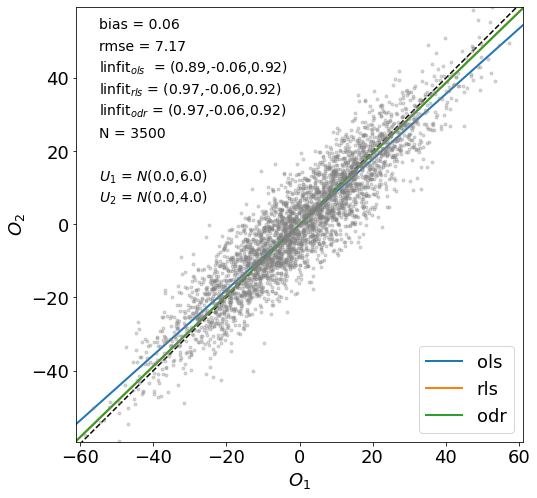

In [6]:

bias, rmse, slope, intercept, r, n = get_stats(o1,o2, )
_, _, slope_r, intercept_r, r_r, _ = get_stats(o1,o2, linfit='rls')
_, _, slope_o, intercept_o, r_o, _ = get_stats(o1,o2, linfit='odr')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
maxl = 4*sig_t
xx = np.array([-maxl,+maxl])
ax.plot(xx,xx,'k--')
ax.plot(xx,slope*xx + intercept,'-', lw=2, label='ols')
ax.plot(xx,slope_r*xx + intercept_r,'-', lw=2, label='rls')
ax.plot(xx,slope_o*xx + intercept_o,'-', lw=2, label='odr')
ax.plot(o1,o2,'.',color='gray',alpha=0.3)
ax.axis('equal')
maxl -= 0.5*sig_t
ax.set_xlim(-maxl,+maxl)
ax.set_ylim(-maxl,+maxl)
ax.set_xlabel(r'$O_1$')
ax.set_ylabel(r'$O_2$')
ax.legend(loc='lower right')

fs = 14
ystep = 0.05
ystart = 0.95
ax.text(0.05,ystart,'bias = {:.2f}'.format(bias),transform=ax.transAxes, fontsize=fs); ystart -= ystep
ax.text(0.05,ystart,'rmse = {:.2f}'.format(rmse),transform=ax.transAxes, fontsize=fs); ystart -= ystep
ax.text(0.05,ystart,r'linfit$_{ols}$ ' +' = ({:.2f},{:.2f},{:.2f})'.format(slope, intercept,r),transform=ax.transAxes, fontsize=fs); ystart -= ystep
ax.text(0.05,ystart,r'linfit$_{rls}$' + ' = ({:.2f},{:.2f},{:.2f})'.format(slope_r, intercept_r,r_r),transform=ax.transAxes, fontsize=fs); ystart -= ystep
ax.text(0.05,ystart,r'linfit$_{odr}$' + ' = ({:.2f},{:.2f},{:.2f})'.format(slope_o, intercept_o,r_o),transform=ax.transAxes, fontsize=fs); ystart -= ystep

ax.text(0.05,ystart,'N = {}'.format(n,),transform=ax.transAxes, fontsize=fs); ystart -= ystep
ystart -= ystep
ax.text(0.05,ystart,r'$U_1$ = $N$({:.1f},{:.1f})'.format(0.,sig_u1),transform=ax.transAxes, fontsize=fs); ystart -= ystep
ax.text(0.05,ystart,r'$U_2$ = $N$({:.1f},{:.1f})'.format(0.,sig_u2),transform=ax.transAxes, fontsize=fs); ystart -= ystep

plt.show()

Observe how the ordinary least square returns a linear fit that is away from the 1-to-1 line (althought both $O_1$ and $O_2$ are un-biased observations of the unknown truth), while the orthogonal distance regression is closer (ODR).

Note also the magnitude of the RMSE computed between $O_1$ and $O_2$, which is a combination of the unceratinties of $U_1$ and $U_2$. In the general case when the validation data $O_1$ has non-zero uncertainty, the RMSE of $O_2$ to $O_1$ is larger than the uncertainty of $O_2$ to the truth (which is unknown).

Here we used the ODR in its most basic form where it considers that $U_1$ and $U_2$ are the same. This is why it returns similar results to the rotated least square (RLS). ODR has many more options.  